## Farm Predict Replication
UROP2100F, Michael Yeung, Apr 2022

In [6]:
#!conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch -y

In [467]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt
import datetime as dt; from collections import Counter
import torch; import re; import sys; import warnings
from scipy.linalg import svd; from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
warnings.filterwarnings("ignore")
print('** DEVICE **\n')
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.'); device = torch.device("cpu")
print('\n** PATHS **\n')
DATA_PATH = './data/'; OUTPUT_PATH = './output/'
print('Input:\t%s\nOutput:\t%s' % (DATA_PATH, OUTPUT_PATH))

** DEVICE **

There are 7 GPU(s) available.
Device name: NVIDIA GeForce RTX 3090

** PATHS **

Input:	./data/
Output:	./output/


In [461]:
def sizeof_fmt(num, suffix='B'):
    # ref: https://stackoverflow.com/questions/24455615/python-how-to-display-size-of-all-variables
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)
print('** VARIABLES AND SIZE **\n')
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>15}: {:>8}".format(name, sizeof_fmt(size)))

** VARIABLES AND SIZE **

      data_test:  7.1 GiB
            ___: 28.7 MiB
   test_results: 28.7 MiB
           _435: 28.7 MiB
           _420: 26.5 MiB
          bp_df:  4.7 MiB
           _418:  4.5 MiB
  words_freq_df:  3.0 MiB
            _57:  1.4 MiB
          y_hat: 704.6 KiB


In [96]:
data = pd.read_parquet(DATA_PATH+'preprocessed_data_1.parquet.gzip')

In [97]:
print(data.shape); data.head(3)

(472693, 7)


,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,jieba_content
0,181899,600323,2010-01-04,0.006658,-0.001522,-0.030300,"[南海发展nt, 水价n, 如期t, 上调v, 增厚v, 业绩n, 约d, 事项n, 公司n..."
1,181900,002024,2010-01-04,-0.004292,-0.022783,-0.047744,"[苏宁ns, 电器n, 内外s, 兼修v, 进入v, 新一轮nz, 增长期n, 投资vn, ..."
2,181901,002092,2010-01-04,0.030815,0.018962,0.055390,"[泰ns, 化学n, 发布v, 准东ns, 井田nr, 勘探vn, 报告n, 煤炭n, 开发..."


In [98]:
data.date = data.date.map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

In [99]:
def filter_av(words):
    av_words = []
    for s in words:
        pos = str(re.findall(r'[A-z]+', s))[2:-2]
        if pos in ['a','v']:
            av_words.append(s)
    return av_words

In [100]:
data['jieba_content'] = data.jieba_content.map(filter_av)

In [101]:
data_test = data.loc[data.date>=dt.datetime(2015,1,1)]

In [46]:
# Run this carefully. It may overwrite featurized data.
data_train = data.loc[data.date<dt.datetime(2015,1,1)]

In [102]:
data_train.shape, data_test.shape

((180353, 7), (292340, 7))

### Word Frequencies of Training Data

In [25]:
# count words in training data (2010-2014)
print('[{Tm}]\tStart Loading'.format(Tm=dt.datetime.now()))
words_freq = None
for year in range(2010,2015):
    print('[{Tm}]\tLoading Year {Yr}'.format(Tm=dt.datetime.now(),Yr=year))
    data_train_seg = data.loc[(data.date>=dt.datetime(year,1,1))\
                              &(data.date<dt.datetime(year+1,1,1))]
    if words_freq is None:
        words_freq = Counter(data_train_seg.jieba_content.map(set).map(list).sum())
    else:
        words_freq += Counter(data_train_seg.jieba_content.map(set).map(list).sum())

[2022-03-30 09:14:22.460183]	Start Loading
[2022-03-30 09:14:22.460813]	Loading Year 2010
[2022-03-30 09:15:01.938778]	Loading Year 2011
[2022-03-30 09:16:00.122672]	Loading Year 2012
[2022-03-30 09:17:36.576772]	Loading Year 2013
[2022-03-30 09:19:12.966167]	Loading Year 2014


In [27]:
words_freq_df = pd.DataFrame.from_dict(words_freq, orient='index').reset_index()
words_freq_df.to_csv(OUTPUT_PATH+'words_freq_train.csv')

### Featurize Data (Words -> Numbers)

In [215]:
words_freq_df = pd.read_csv(OUTPUT_PATH+'words_freq_train.csv',index_col=0)

In [216]:
words_freq_df = words_freq_df\
.rename(columns={words_freq_df.columns[0]:'word',words_freq_df.columns[1]:'freq'})\
.sort_values(by='freq',ascending=False)
print(words_freq_df.shape); words_freq_df.head(3)

(29818, 2)


,word,freq
27,增长v,152035
69,收入v,129168
30,维持v,127527


#### Defining "Frequent Words"
- 3000 most frequent words (adjectives and verbs only)

In [217]:
words_used = list(words_freq_df[:3000]['word'])
#words_used = list(words_freq_df.loc[words_freq_df.freq>=len(data_train)*0.001].word)
len(words_used)

3000

In [108]:
# require: words_used (global var) well defined
def featurize(words_list):
    c = Counter(words_list)
    return [c[w] for w in words_used]

In [78]:
data_train['jieba_content'] = data_train.jieba_content.map(featurize)

In [80]:
data_train.to_parquet('data_train_featurized.parquet.gzip')

In [79]:
data_train.head(3)

,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,jieba_content
0,181899,600323,2010-01-04,0.006658,-0.001522,-0.030300,"[2, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, ..."
1,181900,002024,2010-01-04,-0.004292,-0.022783,-0.047744,"[6, 2, 1, 0, 6, 1, 0, 0, 1, 0, 0, 3, 0, 1, 0, ..."
2,181901,002092,2010-01-04,0.030815,0.018962,0.055390,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [109]:
data_test['jieba_content'] = data_test.jieba_content.map(featurize)

In [110]:
data_test.to_parquet('data_test_featurized.parquet.gzip')

In [111]:
data_test.head(3)

,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,jieba_content
180353,672010,600315,2015-01-05,0.017743,0.044812,0.015762,"[0, 0, 2, 0, 0, 0, 2, 1, 8, 0, 4, 1, 0, 1, 0, ..."
180354,672047,600315,2015-01-05,0.017743,0.044812,0.015762,"[1, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 1, ..."
180355,672017,000063,2015-01-05,0.030515,0.066843,-0.057285,"[0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Farm Predict

In [2]:
%time data_train = pd.read_parquet('data_train_featurized.parquet.gzip', engine='fastparquet')
data_train = data_train.sort_values(by='date')
data_train.head(3)

CPU times: user 25.4 s, sys: 5.94 s, total: 31.3 s
Wall time: 31.3 s


,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,jieba_content
0,181899,600323,2010-01-04,0.006658,-0.001522,-0.030300,"[2, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, ..."
31,182415,002068,2010-01-04,0.007414,0.051910,-0.029193,"[4, 0, 1, 0, 0, 2, 2, 1, 1, 1, 0, 1, 4, 0, 0, ..."
32,182419,000860,2010-01-04,0.003120,0.025750,-0.014979,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ..."


In [3]:
X_train = torch.tensor(np.stack(data_train.jieba_content.values)).type(torch.float32).cuda()
y_train = torch.tensor(np.array(data_train.specret_2d)).type(torch.float32).cuda()
del data_train

- Eigenvalues of $XX^T$ is a superset of Eigenvalues of $X^TX$ with additional zeros (which are not k "largest" Eigenvalues).
- Eigenvectors of $XX^T$ can be calcuated easily based Eigenvectors of $X^TX$ as follows:
- Let $\vec{v}$ be eigenvector of $X^TX$ with $\lambda\neq0$,
- then $X^TX\vec{v}=\lambda\vec{v} \implies XX^T(X\vec{v})=\lambda (X\vec{v})\implies (X\vec{v})$ is an eigenvector of $XX^T$.
- https://math.stackexchange.com/questions/1247983/eigenvectors-and-eigenvalues-from-xtx-to-xxt

In [4]:
%time eigenvals_xtx, eigenvecs_xtx = torch.eig((X_train.T@X_train).cpu(), eigenvectors=True)

CPU times: user 9min 25s, sys: 13.2 s, total: 9min 38s
Wall time: 8.36 s


In [5]:
def extract_real(cplx):
    real_part = []
    for e in cplx:
        if e[1] != 0:
            real_part.append(0)
        else:
            real_part.append(e[0])
    return torch.tensor(real_part).type(torch.float32)

In [6]:
# largest k eigenvalues
eigenvals_topk = torch.topk(extract_real(eigenvals_xtx),100).indices
XV = torch.nn.functional.normalize((X_train@eigenvecs_xtx.cuda()).T,p=2).T[:,eigenvals_topk]
XV.shape

torch.Size([180353, 100])

In [392]:
pd.Series(extract_real(eigenvals_xtx)).sort_values(ascending=False)[:100].sum()\
/pd.Series(extract_real(eigenvals_xtx)).sort_values(ascending=False).sum()

0.7450507

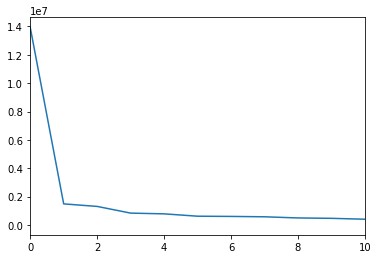

In [389]:
plt.plot(pd.Series(extract_real(eigenvals_xtx)).sort_values(ascending=False))
plt.xlim(0,10); plt.show()

Note: $XV = X[\vec{v}_1,\vec{v}_2,\ldots,\vec{v}_{k}]$ are the largest $k$ Eigenvectors of $XX^T$. <br>
We take $k=100$

In [161]:
F_hat = XV.cpu()*(X_train.shape[0])**0.5
B_hat = X_train.T@F_hat.cuda()/(X_train.shape[0])
U_hat = X_train.cpu() - F_hat@B_hat.T.cpu()

In [294]:
# compare 1
B_hat.T@B_hat

tensor([[ 7.7317e+01,  9.4341e-03, -1.2314e-03,  ...,  1.3628e-03,
          5.3186e-03, -5.8545e-03],
        [ 9.4341e-03,  8.2253e+00,  2.1772e-04,  ...,  5.7875e-05,
          2.6519e-04, -2.8591e-05],
        [-1.2314e-03,  2.1772e-04,  7.2315e+00,  ..., -4.2524e-05,
         -2.5561e-04, -1.0396e-04],
        ...,
        [ 1.3628e-03,  5.7875e-05, -4.2524e-05,  ...,  2.9798e-01,
         -9.7620e-06, -4.6934e-05],
        [ 5.3186e-03,  2.6519e-04, -2.5561e-04,  ..., -9.7620e-06,
          2.9724e-01, -4.7630e-05],
        [-5.8545e-03, -2.8591e-05, -1.0396e-04,  ..., -4.6934e-05,
         -4.7630e-05,  2.9555e-01]], device='cuda:0')

In [239]:
BTB = torch.tensor(np.diag(torch.topk(extract_real(eigenvals_xtx),100).values))/len(X_train)

In [295]:
# compare 2
BTB

tensor([[77.3112,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  8.2257,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  7.2336,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.2980,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.2972,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.2956]])

In [324]:
reg1 = LinearRegression().fit(F_hat.cpu(), y_train.cpu())
y_hat = reg1.predict(F_hat.cpu())

In [325]:
a_hat = reg1.intercept_
b_hat = reg1.coef_

In [326]:
y_residual = y_train.cpu() - y_hat

In [327]:
corrs = [pearsonr(U_hat.T[j].cpu(), y_train.cpu())[0] for j in range(len(U_hat.T))]
corrs = [0 if x != x else abs(x) for x in corrs]

In [399]:
#TODO: include more words
MIN_CORR = 0.0025
df = pd.DataFrame(corrs,columns=['corr'])
df['isCharged'] = df['corr'].map(lambda x: abs(x)>MIN_CORR)
charged_index = list(df[df.isCharged].index)
print(str(len(charged_index))+' ({Pct}%)'.format(Pct=round(len(charged_index)/len(corrs),3)*100))

423 (14.099999999999998%)


In [400]:
U_hat_S_hat = U_hat.T[charged_index].T
U_hat_S_hat.shape

torch.Size([180353, 423])

In [401]:
reg2 = Lasso(alpha=0.0001)
reg2.fit(U_hat_S_hat.cpu(),y_residual)

Lasso(alpha=0.0001)

In [402]:
beta_hat = reg2.coef_

### Testing

In [417]:
data_test = pd.read_parquet('data_test_featurized.parquet.gzip', engine='fastparquet')
data_test = data_test.sort_values(by='date')
data_test.head(3)

,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,jieba_content
180353,672010,600315,2015-01-05,0.017743,0.044812,0.015762,"[0, 0, 2, 0, 0, 0, 2, 1, 8, 0, 4, 1, 0, 1, 0, ..."
180567,672842,300310,2015-01-05,-0.026962,0.004341,0.004178,"[4, 3, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, ..."
180571,672845,600277,2015-01-05,-0.002883,-0.026105,-0.017401,"[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 2, ..."


In [ ]:
X_test = torch.tensor(np.stack(data_test.jieba_content.values)).cuda()
y_test = torch.tensor(np.array(data_test.specret_2d)).cuda()
del data_test

In [404]:
b_hat = torch.tensor(b_hat)
beta_hat = torch.tensor(beta_hat)

In [405]:
BTB

tensor([[77.3112,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  8.2257,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  7.2336,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.2980,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.2972,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.2956]])

In [406]:
BTB_inv = torch.linalg.inv(BTB)

In [407]:
f_new_train = (BTB_inv.cuda()@B_hat.T)@X_train.T.type(torch.float32)
f_new_test = (BTB_inv.cpu()@B_hat.T.cpu())@X_test.cpu().T.type(torch.float32)

In [408]:
u_new_train = X_train.T.cpu() - B_hat.cpu()@f_new_train.cpu()
u_new_test = X_test.T.cpu() - B_hat.cpu()@f_new_test.cpu()

In [409]:
y_pred_train = a_hat + b_hat@f_new_train.cpu() + np.array(beta_hat@u_new_train.type(torch.float64)[charged_index])
y_pred_test = a_hat + b_hat@f_new_test.cpu() + beta_hat@u_new_test.type(torch.float64)[charged_index]

In [410]:
b_hat@f_new_train.cpu()

tensor([0.0163, 0.0023, 0.0024,  ..., 0.0000, 0.0104, 0.0228])

In [411]:
beta_hat.type(torch.float32)@u_new_train[charged_index]

tensor([-0.0044, -0.0028,  0.0006,  ...,  0.0000,  0.0607,  0.0060])

In [427]:
import matplotlib.pyplot as plt
print('Training Spearsan:\t',spearmanr(y_train.cpu(), y_pred_train.cpu())[0])
print('Testing Spearsan:\t',spearmanr(y_test.cpu(), y_pred_test.cpu())[0])
print('Training Pearson:\t',pearsonr(y_train.cpu(), y_pred_train.cpu())[0])
print('Testing Pearson:\t',pearsonr(y_test.cpu(), y_pred_test.cpu())[0])

Training Spearsan:	 0.15465683873842612
Testing Spearsan:	 0.11616596691912204
Training Pearson:	 0.1594125312423485
Testing Pearson:	 0.09183660287271815


In [419]:
data_test.head()

,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,jieba_content
180353,672010,600315,2015-01-05,0.017743,0.044812,0.015762,"[0, 0, 2, 0, 0, 0, 2, 1, 8, 0, 4, 1, 0, 1, 0, ..."
180567,672842,300310,2015-01-05,-0.026962,0.004341,0.004178,"[4, 3, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, ..."
180571,672845,600277,2015-01-05,-0.002883,-0.026105,-0.017401,"[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 2, ..."
180453,672374,002349,2015-01-05,-0.005686,-0.032378,0.087329,"[0, 1, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, ..."
180474,672553,600309,2015-01-05,0.042324,0.048550,0.039281,"[0, 0, 3, 1, 3, 1, 1, 1, 0, 2, 2, 1, 0, 0, 1, ..."


In [415]:
y_test

tensor([ 0.0448,  0.0043, -0.0261,  ..., -0.0620, -0.0227, -0.1572],
       device='cuda:0', dtype=torch.float64)

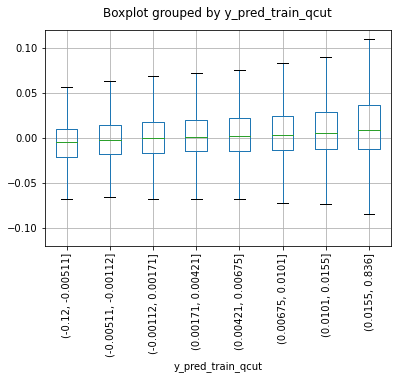

In [413]:
bp_df = pd.DataFrame(np.hstack((np.array(y_train.cpu()).reshape(-1,1),np.array(y_pred_train.cpu()).reshape(-1,1))),\
                     columns=['y_train','y_pred_train'])
bp_df['y_pred_train_qcut'] = pd.qcut(y_pred_train,q=8)
bp_df.boxplot(column=['y_train'], by='y_pred_train_qcut', showfliers=False)
plt.ylim(-0.12,0.12)
plt.xticks(rotation=90); plt.title(''); plt.show()

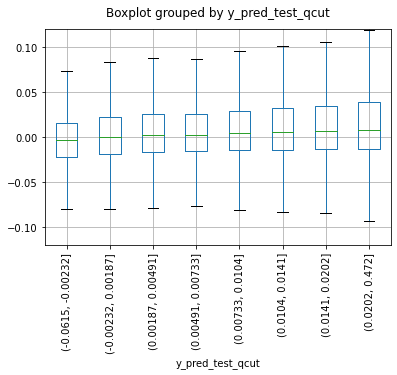

In [414]:
bp_df = pd.DataFrame(np.hstack((np.array(y_test.cpu()).reshape(-1,1),np.array(y_pred_test.cpu()).reshape(-1,1))),\
                     columns=['y_test','y_pred_test'])
bp_df['y_pred_test_qcut'] = pd.qcut(y_pred_test,q=8)
bp_df.boxplot(column=['y_test'], by='y_pred_test_qcut', showfliers=False)
plt.ylim(-0.12,0.12)
plt.xticks(rotation=90); plt.title(''); plt.show()

In [431]:
test_results = data_test[['ID','SecuCode','date','specret_2d']]
test_results['y_pred'] = y_pred_test.cpu()

In [434]:
test_results.to_parquet(OUTPUT_PATH+'test_results_FarmPredict.parquet.gzip')

In [363]:
np.array([beta_hat,np.array(words_used)[charged_index]])

array([tensor([-0.0000, 0.0027, -0.0000, 0.0080, 0.0060, 0.0039, 0.0017, 0.0080, 0.0028,
               0.0026, 0.0045, 0.0033, 0.0023, 0.0050, 0.0050, 0.0000, 0.0000, 0.0226,
               0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.0000, 0.0178, 0.0000, 0.0000,
               0.0000, 0.0029, 0.0000, 0.0000, 0.0000, 0.1171, 0.0000, 0.0024, 0.0000,
               0.0000, 0.1000, 0.0000], dtype=torch.float64)                            ,
       array(['收购v', '巨大a', '注入v', '承诺v', '相当于v', '优秀a', '可比v', '参考v', '依赖v',
              '变更v', '拟向v', '面对v', '跨v', '抓住v', '有着v', '有别于v', '变为v', '复牌v',
              '激进v', '根本a', '付费v', '看待v', '增价v', '已成v', '置入v', '抢v', '最全a', '动v',
              '收视v', '等于v', '超前v', '易于v', '点播v', '蕴含v', '制胜v', '某种程度v', '涨停v',
              '概括v', '播控v'], dtype='<U5')                                        ],
      dtype=object)

In [382]:
beta_df = pd.DataFrame(np.vstack((np.array(beta_hat).T,np.array(words_used)[charged_index].T)).T,columns=['beta','word'])
beta_df['beta'] = beta_df.beta.map(float)
print(beta_df.loc[beta_df.beta>0].sort_values(by='beta',ascending=False))
#print(beta_df.loc[beta_df.beta<=0].sort_values(by='beta',ascending=True))

        beta  word
32  0.117072   点播v
37  0.100017   概括v
17  0.022636   复牌v
24  0.017775   置入v
3   0.008020   承诺v
7   0.007959   参考v
4   0.006008  相当于v
13  0.005005   抓住v
14  0.004975   有着v
10  0.004466   拟向v
5   0.003914   优秀a
11  0.003332   面对v
28  0.002940   收视v
8   0.002844   依赖v
1   0.002657   巨大a
9   0.002616   变更v
34  0.002379   制胜v
12  0.002281    跨v
6   0.001683   可比v


In [380]:
beta_df

,beta,word
0,-0.000000,收购v
1,0.002657,巨大a
2,-0.000000,注入v
3,0.008020,承诺v
4,0.006008,相当于v
5,0.003914,优秀a
6,0.001683,可比v
7,0.007959,参考v
8,0.002844,依赖v
9,0.002616,变更v
